### Overview
* Seasonal decomposition / ETS: Error, Trend, Seasonality
    * Additive or Multiplicative
        * Additive: Trend + Seasonal + Error (e.g. USD10mn increase in sales during holidays)
        * Multiplicative: Trend * Seasonal * Error (e.g. 20% jump in sales during holidays)
* Error metrics - MAE, RMSE, MAPE (mean absolute *percentage* error)
* **Holt-Winters** - exponential smoothing on level, trend, & seasonality
    * both additive and multiplicative variants
    * Explanations: [Link1](timeseriesreasoning), [Link2](https://orangematter.solarwinds.com/2019/12/15/holt-winters-forecasting-simplified)
---

### Example 1 - Using Bike Sharing [dataset](https://www.kaggle.com/datasets/contactprad/bike-share-daily-data)
* assign datetime as index
* set 'frequency'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Time-series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

# Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress 'futurewarnings' from Statsmodels and TSA
import warnings
warnings.filterwarnings("ignore")

C:\Users\uditg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\uditg\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('data/daily_bike_sharing.csv')

In [3]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df.dtypes  #dteday is string type

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
# use date as index. parse_dates converts from string to datetime
df = pd.read_csv('data/daily_bike_sharing.csv', 
                 index_col='dteday', parse_dates=True)

In [6]:
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
# datetime, Frequency is NONE
df.index[0:5]

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05'],
              dtype='datetime64[ns]', name='dteday', freq=None)

In [8]:
# setting Frequency to Daily
df = df.asfreq('D')
df.index[0:5]

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05'],
              dtype='datetime64[ns]', name='dteday', freq='D')

In [9]:
df.shape

(731, 15)

In [10]:
df['instant'].nunique()

731

In [11]:
df.isna().sum()

instant       0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [12]:
df['season'].value_counts()

3    188
2    184
1    181
4    178
Name: season, dtype: int64

In [13]:
# retaining only relevant columns
df = df.loc[:,['cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

In [14]:
df = df.rename(columns={'cnt':'y'})
df.head(1)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


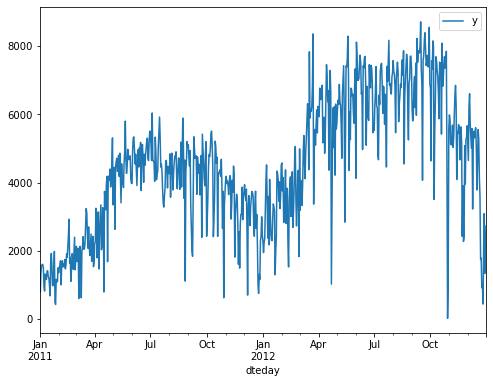

In [15]:
#quick plot - notice trend, seasonality (over summer)
df['y'].plot(figsize=(8,6), legend=True);

---
### Seasonal Decomposition

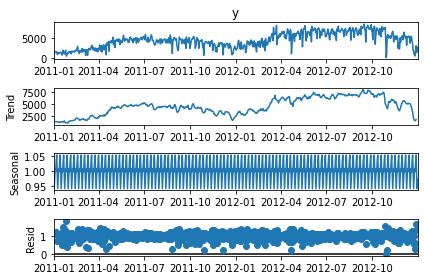

In [16]:
decomp = seasonal_decompose(x = df['y'], model = 'multiplicative')
decomp.plot();

In [17]:
type(decomp)

statsmodels.tsa.seasonal.DecomposeResult

In [18]:
# decomp = seasonal_decompose(x = df['y'], model = 'additive')
# decomp.plot();

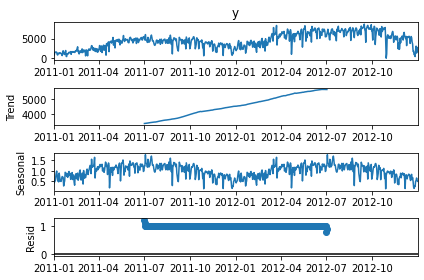

In [19]:
decomp = seasonal_decompose(x = df['y'], model = 'multiplicative', period=365)
decomp.plot();

### Seasonality graph

In [20]:
df['y'].resample(rule='M').agg(['sum','mean'])

,sum,mean
dteday,,
2011-01-31,38189,1231.903226
2011-02-28,48215,1721.964286
2011-03-31,64045,2065.967742
2011-04-30,94870,3162.333333
2011-05-31,135821,4381.322581
2011-06-30,143512,4783.733333
2011-07-31,141341,4559.387097
2011-08-31,136691,4409.387097
2011-09-30,127418,4247.266667


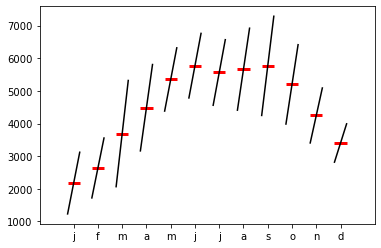

In [21]:
# 'MS' = Monthly + Start date.. 'M' would give EOM date
# error bars are just based on couple of data-points
month_plot(df['y'].resample(rule='MS').mean());

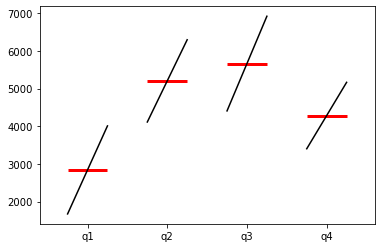

In [22]:
quarter_plot(df['y'].resample(rule='Q').mean());

---
### Train-test split
* Keep test-time-period similar to how the model will be used in practice

In [23]:
test_days = 31
train = df.iloc[:-test_days, :]
test  = df.iloc[-test_days:, :]

In [24]:
train.shape, test.shape

((700, 8), (31, 8))

In [25]:
train.tail(2)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-11-29,5323,0,1,1,0.280870,0.298422,0.555652,0.115522
2012-11-30,5668,0,1,1,0.298333,0.323867,0.649583,0.058471


In [26]:
test.head(2)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-01,5191,0,0,2,0.298333,0.316904,0.806667,0.059704
2012-12-02,4649,0,0,2,0.347500,0.359208,0.823333,0.124379


---
### Holt-Winters model

In [27]:
model = ExponentialSmoothing(endog = train['y'],  #endog = endogeneous
                             trend = 'mul', seasonal = 'mul', seasonal_periods = 7).fit()

In [28]:
preds_hw = model.forecast(steps=test_days).rename('HW')

In [29]:
preds_hw.head()

2012-12-01    4703.434234
2012-12-02    4152.109049
2012-12-03    4376.195688
2012-12-04    4211.156937
2012-12-05    4896.528749
Freq: D, Name: HW, dtype: float64

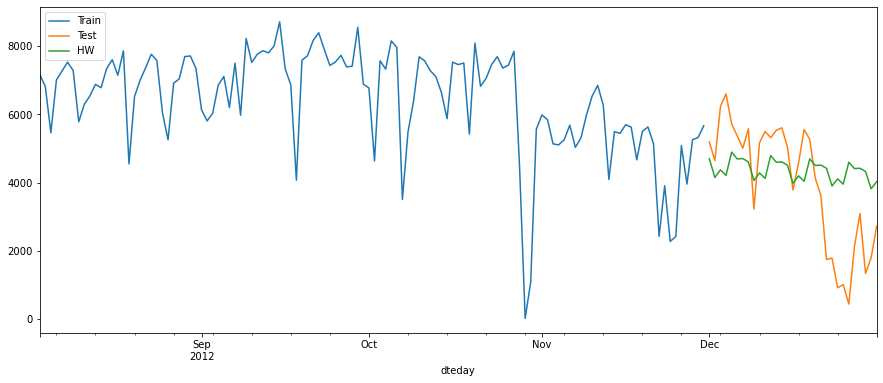

In [30]:
plt.figure(figsize = (15,6))
train['y'][-120:].plot(label = 'Train');   #plotting last few days for better graphs
test['y'].plot(label = 'Test');
preds_hw.plot();
plt.legend(loc='upper left');

### Model Assessment

In [31]:
mean_absolute_error(test['y'], preds_hw).round(2)

1389.53

In [32]:
np.sqrt(mean_squared_error(test['y'], preds_hw)).round(2)

1712.99

In [33]:
((test['y'] - preds_hw)/test['y']).abs().mean()*100         # ~90%, useless at this point

88.14082811284679

In [34]:
preds_hw.to_csv('preds_hw.csv')

### Alternate seasonality

In [35]:
def fit_model(seasonal_periods):
    model = ExponentialSmoothing(endog = train['y'], trend = 'mul', seasonal = 'mul',
                                 seasonal_periods = seasonal_periods).fit()
    preds = model.forecast(steps=test_days).rename('HW')
    
    plt.figure(figsize = (15,6))
    train['y'][-120:].plot(label = 'Train'); 
    test['y'].plot(label = 'Test');
    preds.plot();
    plt.legend(loc='upper left');
    
    print('MAE: ' , mean_absolute_error(test['y'], preds).round(2))
    print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds)).round(2))
    print('MAPE: ', round(((test['y'] - preds)/test['y']).abs().mean(),4)*100)

MAE:  956.98
RMSE:  1344.2
MAPE:  44.24


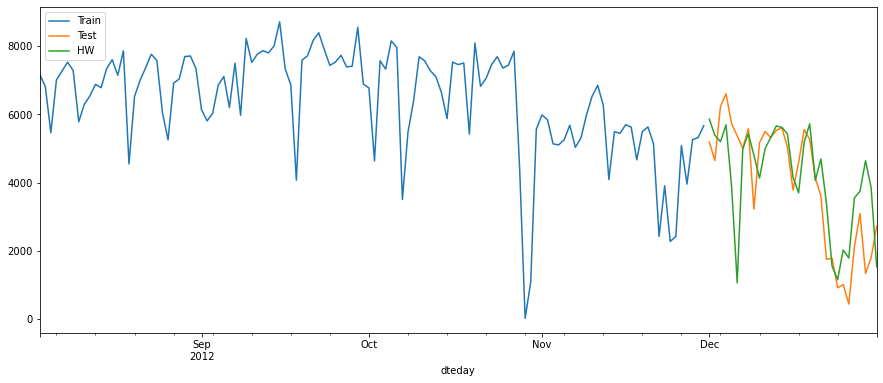

In [36]:
fit_model(365);

---
### Example 2 - Airmiles

In [37]:
# monthly time series - with start-of-month dates
df = pd.read_csv('data/airmiles.csv', index_col='Date')

In [38]:
df.head(2)

,airmiles
Date,
1/1/1996,30983174
1/2/1996,32147663


In [39]:
df.shape

(113, 1)

In [40]:
df.tail(2)

,airmiles
Date,
1/4/2005,48152585
1/5/2005,50047901


In [41]:
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

In [42]:
df.index[:5]  #freq=None

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [43]:
df = df.asfreq('MS')
df.index[:5]

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

<AxesSubplot:xlabel='Date'>

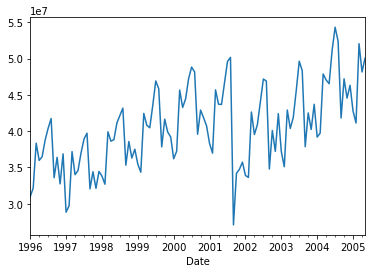

In [44]:
df['airmiles'].plot()

In [45]:
test_period = 12
train = df.iloc[:-test_period, :]
test  = df.iloc[-test_period:, :]

print(train.shape, test.shape)

(101, 1) (12, 1)


In [46]:
model = ExponentialSmoothing(endog = train, trend = 'mul', seasonal = 'mul',
                             seasonal_periods = 12).fit()
preds = model.forecast(steps=test_period)

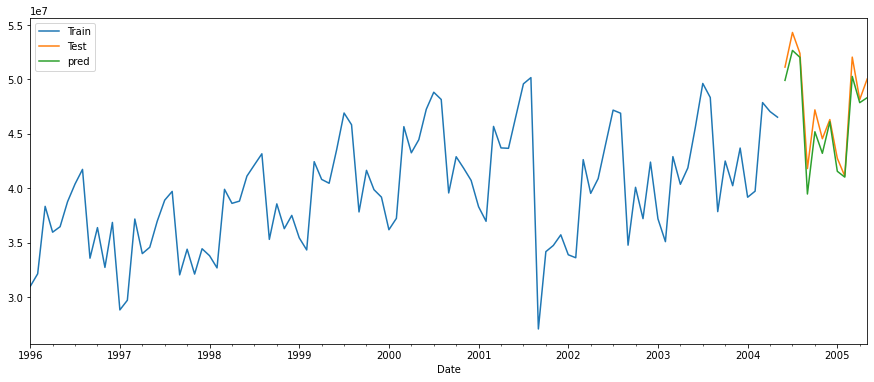

In [47]:
plt.figure(figsize = (15,6))
train['airmiles'].plot(label = 'Train'); 
test['airmiles'].plot( label = 'Test');
preds.plot(label = 'pred');
plt.legend();

In [48]:
print('Average level: ', round(df['airmiles'].mean(),0))
print('MAE:  ', mean_absolute_error(test['airmiles'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['airmiles'], preds)).round(0))
print('MAPE: ', round(((test['airmiles'] - preds)/test['airmiles']).abs().mean()*100,2))

Average level:  40505240.0
MAE:   1182551.0
RMSE:  1393833.0
MAPE:  2.49


MAE:   1333707.0
RMSE:  1520693.0
MAPE:  2.81


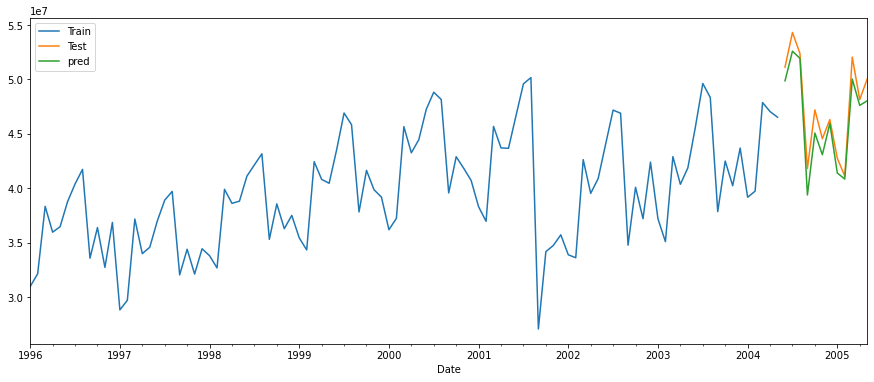

In [49]:
# Trend is additive, perhaps? - Performance is worse than before
model = ExponentialSmoothing(endog = train, trend = 'add', seasonal = 'mul',seasonal_periods = 12).fit()
preds = model.forecast(steps=test_period)

plt.figure(figsize = (15,6))
train['airmiles'].plot(label = 'Train'); 
test['airmiles'].plot( label = 'Test');
preds.plot(label = 'pred');
plt.legend();

print('MAE:  ', mean_absolute_error(test['airmiles'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['airmiles'], preds)).round(0))
print('MAPE: ', round(((test['airmiles'] - preds)/test['airmiles']).abs().mean()*100,2))

In [50]:
model.summary()

Dep. Variable:,airmiles,No. Observations:,101
Model:,ExponentialSmoothing,SSE,357714662543469.750
Optimized:,True,AIC,2950.459
Trend:,Additive,BIC,2992.301
Seasonal:,Multiplicative,AICC,2958.801
Seasonal Periods:,12,Date:,"Sun, 12 Jun 2022"
Box-Cox:,False,Time:,16:59:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4646429,alpha,True
smoothing_trend,0.0244549,beta,True


The End!